<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_ensemble_stock_trading_ICAIF_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from torchvision.models.resnet import resnet18

In [1]:
%load_ext autoreload
%autoreload 2

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [2]:
# ## install finrl library
# !pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.interactive(False)
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from stable_baselines3.common.vec_env import SubprocVecEnv
from finrl.model.models import DRLAgent, DRLEnsembleAgent
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline
from stable_baselines3 import A2C

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools
import zipfile
import datetime

In [4]:
import torch

torch.cuda.is_available(),torch.cuda.current_device(),torch.cuda.device(0),torch.cuda.device_count(),torch.cuda.get_device_name(0)

(True, 0, <torch.cuda.device at 0x1b008f1e848>, 1, 'GeForce GTX 1070 Ti')

In [5]:
matplotlib.get_backend()

'agg'

<a id='1.4'></a>
## 2.4. Create Folders

In [31]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [12]:
# df = pd.read_csv("C:/Users/Mcian/Downloads/day_trader_bot/dukascopy/TSLA.USUSD_Candlestick_1_M_BID_30.03.2018-30.03.2021.csv")
# df = df[df['Volume'] > 0]
# df = pd.concat([df, 
#                 pd.read_csv("C:/Users/Mcian/Downloads/day_trader_bot/dukascopy/BTCUSD_Candlestick_1_M_BID_17.03.2018-17.03.2021.csv")])
zf = zipfile.ZipFile('firstratedata/us3000_tickers_S-T_1min_76pab.zip') 
df = pd.read_csv(zf.open('TSLA_1min.txt'), names=['Local time', 'Open', 'High', 'Low', 'Close', 'Volume'])


df['tic'] = 'TSLA'
df = df.iloc[1225000:]
df['Local time'] = pd.to_datetime(df['Local time'])
df = df.resample('min', on='Local time').max().fillna(method='ffill')
df = df[[t.time() > datetime.time(9, 30) and t.time() < datetime.time(16, 30) for t in df['Local time']]]

BadZipFile: File is not a zip file

In [89]:
# df['Local time'] = pd.to_datetime(df['Local time'])
df['date'] = df['Local time'].apply(lambda x: x.isoformat())
df['day'] = df['Local time'].apply(lambda x: x.weekday())
df['hour'] = df['Local time'].apply(lambda x: x.hour+x.minute/60)
# del df['Local time']
df.columns = [c.lower() for c in df.columns]
df.reset_index(drop=True, inplace=True)

In [18]:
df = pd.read_csv('firstratedata/TSLA.csv')

In [19]:
df.drop_duplicates(inplace=True)

In [20]:
df.head()

,local time,open,high,low,close,volume,previous_day_close,previous_day_high,previous_day_low,premarket_high,premarket_low,tic,date,day,hour
0,2011-06-30 09:30:00,5.700,5.720,5.700,5.702,256620.0,5.79,5.798,5.666,5.702,5.702,TSLA,2011-06-30T09:30:00,3,9.500000
1,2011-06-30 09:31:00,5.708,5.734,5.700,5.724,65105.0,5.79,5.798,5.666,5.702,5.702,TSLA,2011-06-30T09:31:00,3,9.516667
2,2011-06-30 09:32:00,5.732,5.732,5.700,5.722,16000.0,5.79,5.798,5.666,5.702,5.702,TSLA,2011-06-30T09:32:00,3,9.533333
3,2011-06-30 09:33:00,5.722,5.722,5.718,5.718,6500.0,5.79,5.798,5.666,5.702,5.702,TSLA,2011-06-30T09:33:00,3,9.550000
4,2011-06-30 09:34:00,5.716,5.716,5.712,5.714,17000.0,5.79,5.798,5.666,5.702,5.702,TSLA,2011-06-30T09:34:00,3,9.566667


In [21]:
df.tail()

,local time,open,high,low,close,volume,previous_day_close,previous_day_high,previous_day_low,premarket_high,premarket_low,tic,date,day,hour
71233,2021-03-22 11:27:00,692.3450,692.4400,691.5080,691.860,32875.0,642.6099,668.3,625.5387,685.88,659.8,TSLA,2021-03-22T11:27:00,0,11.450000
71234,2021-03-22 11:28:00,691.9600,692.1000,690.4200,690.420,60257.0,642.6099,668.3,625.5387,685.88,659.8,TSLA,2021-03-22T11:28:00,0,11.466667
71235,2021-03-22 11:29:00,690.4800,691.2113,689.8400,690.813,75871.0,642.6099,668.3,625.5387,685.88,659.8,TSLA,2021-03-22T11:29:00,0,11.483333
71236,2021-03-22 11:30:00,690.8900,691.7100,690.3229,691.000,53994.0,642.6099,668.3,625.5387,685.88,659.8,TSLA,2021-03-22T11:30:00,0,11.500000
71237,2021-03-22 11:31:00,690.9474,691.5000,689.9900,691.220,39766.0,642.6099,668.3,625.5387,685.88,659.8,TSLA,2021-03-22T11:31:00,0,11.516667


In [22]:
df.shape, df.drop_duplicates().shape

((71238, 15), (71238, 15))

In [23]:
df.sort_values(['date','tic']).head()

,local time,open,high,low,close,volume,previous_day_close,previous_day_high,previous_day_low,premarket_high,premarket_low,tic,date,day,hour
0,2011-06-30 09:30:00,5.700,5.720,5.700,5.702,256620.0,5.79,5.798,5.666,5.702,5.702,TSLA,2011-06-30T09:30:00,3,9.500000
1,2011-06-30 09:31:00,5.708,5.734,5.700,5.724,65105.0,5.79,5.798,5.666,5.702,5.702,TSLA,2011-06-30T09:31:00,3,9.516667
2,2011-06-30 09:32:00,5.732,5.732,5.700,5.722,16000.0,5.79,5.798,5.666,5.702,5.702,TSLA,2011-06-30T09:32:00,3,9.533333
3,2011-06-30 09:33:00,5.722,5.722,5.718,5.718,6500.0,5.79,5.798,5.666,5.702,5.702,TSLA,2011-06-30T09:33:00,3,9.550000
4,2011-06-30 09:34:00,5.716,5.716,5.712,5.714,17000.0,5.79,5.798,5.666,5.702,5.702,TSLA,2011-06-30T09:34:00,3,9.566667


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [24]:
config.TSLA_TECHNICAL_INDICATORS_LIST

['boll_ub',
 'boll_lb',
 'close_50_sma',
 'close_200_sma',
 'close_9_ema',
 'close_20_ema']

In [25]:
columns = df.columns

In [26]:
columns

Index(['local time', 'open', 'high', 'low', 'close', 'volume',
       'previous_day_close', 'previous_day_high', 'previous_day_low',
       'premarket_high', 'premarket_low', 'tic', 'date', 'day', 'hour'],
      dtype='object')

In [27]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TSLA_TECHNICAL_INDICATORS_LIST,
                    use_turbulence=False,
                    user_defined_feature=True)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added user defined features


In [30]:
indicators = [c for c in processed.columns if c not in columns] + ['previous_day_close', 'previous_day_high', 'previous_day_low', 'premarket_high', 'premarket_low']

In [31]:
indicators

['boll_ub',
 'boll_lb',
 'close_50_sma',
 'close_200_sma',
 'close_9_ema',
 'close_20_ema',
 'vwap',
 'previous_day_close',
 'previous_day_high',
 'previous_day_low',
 'premarket_high',
 'premarket_low']

In [7]:
indicators = ['boll_ub',
 'boll_lb',
 'close_50_sma',
 'close_200_sma',
 'close_9_ema',
 'close_20_ema',
 'vwap',
 'previous_day_close',
 'previous_day_high',
 'previous_day_low',
 'premarket_high',
 'premarket_low']

In [32]:
if False:
    list_ticker = processed["tic"].unique().tolist()
    list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
    combination = list(itertools.product(list_date,list_ticker))

    processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
    processed_full = processed_full[processed_full['date'].isin(processed['date'])]
    processed_full = processed_full.sort_values(['date','tic'])

    processed_full = processed_full.fillna(0)
else:
    processed_full = processed

In [33]:
processed_full.sample(5)

,local time,open,high,low,close,volume,previous_day_close,previous_day_high,previous_day_low,premarket_high,...,date,day,hour,boll_ub,boll_lb,close_50_sma,close_200_sma,close_9_ema,close_20_ema,vwap
27044,2019-04-04 05:22:00,54.2000,54.2000,54.1640,54.164,7155.0,58.7520,59.2130,57.224,55.000,...,2019-04-04T05:22:00,3,5.366667,54.351591,54.117009,54.262040,59.587433,54.198841,54.225660,54.184946
61094,2020-12-21 08:12:00,667.2359,667.6999,667.0000,667.200,9302.0,661.9296,683.2956,647.060,672.690,...,2020-12-21T08:12:00,0,8.200000,669.104935,665.666525,668.673692,661.146873,667.078368,667.487172,667.129347
39933,2020-04-03 09:35:00,101.3680,102.4980,101.2482,102.166,585580.0,95.2587,100.2000,93.614,106.200,...,2020-04-03T09:35:00,4,9.583333,104.157142,100.995058,103.260280,104.222870,102.119194,102.476451,101.826295
12798,2012-05-30 10:10:00,6.1980,6.1980,6.1840,6.184,10760.0,6.3280,6.3280,6.040,6.256,...,2012-05-30T10:10:00,2,10.166667,6.201094,6.143006,6.184176,6.180988,6.181394,6.174600,6.185055
52710,2020-10-02 04:04:00,431.7400,431.7400,430.0000,430.060,4887.0,439.7400,442.5000,434.860,435.510,...,2020-10-02T04:04:00,4,4.066667,447.064900,425.654740,436.742596,438.005333,432.123551,434.724443,427.603622


In [34]:
if True:
    processed_full.to_csv('processed_full_TSLA.csv', index=False)

In [8]:
if True:    
    processed_full = pd.read_csv('processed_full_TSLA.csv')
    del processed_full['Unnamed: 0']
#     processed_full['local time'] = pd.to_datetime(processed_full['local time'])

In [9]:
processed_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79944 entries, 0 to 79943
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   local time     79944 non-null  object 
 1   open           79944 non-null  float64
 2   high           79944 non-null  float64
 3   low            79944 non-null  float64
 4   close          79944 non-null  float64
 5   volume         79944 non-null  float64
 6   tic            79944 non-null  object 
 7   date           79944 non-null  object 
 8   day            79944 non-null  int64  
 9   hour           79944 non-null  float64
 10  boll_ub        79944 non-null  float64
 11  boll_lb        79944 non-null  float64
 12  close_50_sma   79944 non-null  float64
 13  close_200_sma  79944 non-null  float64
 14  close_9_ema    79944 non-null  float64
 15  close_20_ema   79944 non-null  float64
 16  vwap           79944 non-null  float64
dtypes: float64(13), int64(1), object(3)
memory usage: 

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [10]:
stock_dimension = len(processed_full.tic.unique())
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 1


In [11]:
def cost_function(volume):
    return 0.01

In [12]:
env_kwargs = {
    "hmax": 1.0, 
    'model_name':'TSLA',
    'mode': 'train',
    "initial_amount": 50000, 
    "buy_cost_pct": cost_function, 
    "sell_cost_pct": cost_function, 
    "tech_indicator_list": indicators,
    "print_verbosity":1000,
    "terminal": True,
    "get_gif": False,
#     "minute": 71800
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [13]:
val_size = int(len(processed_full)*0.1)

train_start = processed_full.iloc[:-val_size]['date'].min()
train_end = processed_full.iloc[:-val_size]['date'].max()
val_test_start = processed_full.iloc[-val_size:]['date'].min()
val_test_end = processed_full.iloc[-val_size:]['date'].max()

In [14]:
A2C_model_kwargs = {
    'n_steps': 1,
    'ent_coef': 0.01,
    'learning_rate': 0.001,
    'device': 'cuda',
#     'gamma': 0.5
}

timesteps_dict = {
    'a2c' : 100_000, 
    'ppo' : 100_000, 
    'ddpg' : 50_000
}

In [12]:
processed_full.shape, processed_full[processed_full['volume'] > 0].shape

((79944, 17), (79944, 17))

In [14]:
e_trade_gym = StockTradingEnv(processed_full.iloc[:-val_size], **env_kwargs)

In [39]:
import multiprocessing

n_cores = multiprocessing.cpu_count() - 2
n_cores = 24
print(f"using {n_cores} cores")

#this is our training env. It allows multiprocessing
env, _ = e_train_gym.get_multiproc_env(n = n_cores)

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib
matplotlib.interactive(False)
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import datetime

from finrl.config import config
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from stable_baselines.common.vec_env import SubprocVecEnv
from finrl.model.models import DRLAgent, DRLEnsembleAgent
# from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline
from stable_baselines import a2c

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools
import zipfile
import datetime

indicators = ['boll_ub',
 'boll_lb',
 'close_50_sma',
 'close_200_sma',
 'close_9_ema',
 'close_20_ema',
 'vwap',
 'previous_day_close',
 'previous_day_high',
 'previous_day_low',
 'premarket_high',
 'premarket_low']

if True:    
    processed_full = pd.read_csv('processed_full_TSLA.csv')

stock_dimension = len(processed_full.tic.unique())

def cost_function(volume):
    return 0.001

env_kwargs = {
    "hmax": 1.0, 
    'model_name':'TSLA',
    'mode': 'train',
    "initial_amount": 50000, 
    "buy_cost_pct": cost_function, 
    "sell_cost_pct": cost_function, 
    "tech_indicator_list": indicators,
    "print_verbosity":1000,
    "terminal": True,
    "get_gif": False,
#     "minute": 71800
}

val_size = int(len(processed_full)*0.1)

train_start = processed_full.iloc[:-val_size]['date'].min()
train_end = processed_full.iloc[:-val_size]['date'].max()
val_test_start = processed_full.iloc[-val_size:]['date'].min()
val_test_end = processed_full.iloc[-val_size:]['date'].max()

A2C_model_kwargs = {
#     'n_steps': 5,
#     'ent_coef': 0.01,
#     'learning_rate': 0.001,
#     'device': 'cuda',
#     'gamma': 0.5
}

timesteps_dict = {
    'a2c' : 100_000, 
    'ppo' : 100_000, 
    'ddpg' : 50_000
}

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
env = StockTradingEnv(processed_full.iloc[:-val_size], **env_kwargs)

In [4]:
agent = DRLAgent(env)

In [5]:
model = agent.get_model(
    'a2c',
    policy="CnnPolicy",
    verbose=0,
    model_kwargs=A2C_model_kwargs
)

{}









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




In [8]:
total_timesteps = processed_full.iloc[:-val_size].shape[0] * 10
agent.train_model(
    model,
    tb_log_name=f"a2c/TSLA",
    total_timesteps=total_timesteps,
)

minute: 26000, episode: 20
elapsed_time: 32020.931385993958
total_steps: 641879
num_asset_resets: 1
begin_total_asset: 50000.00
end_total_asset: 33320.40
total_invested: 33309.19
total_reward: -32087.79
total_cost: 13751.03
total_trades: 359
Sharpe: 1.530
minute: 30000, episode: 20
elapsed_time: 32061.8701171875
total_steps: 642920
num_asset_resets: 1
begin_total_asset: 50000.00
end_total_asset: 31823.11
total_invested: 31792.26
total_reward: -33506.96
total_cost: 14328.72
total_trades: 377
Sharpe: 1.452
minute: 31000, episode: 20
elapsed_time: 32075.4446310997
total_steps: 643258
num_asset_resets: 1
begin_total_asset: 50000.00
end_total_asset: 30482.47
total_invested: 30426.19
total_reward: -36165.92
total_cost: 14451.65
total_trades: 381
Sharpe: -8.791
minute: 35000, episode: 20
elapsed_time: 32116.182418584824
total_steps: 644279
num_asset_resets: 1
begin_total_asset: 50000.00
end_total_asset: 36257.07
total_invested: 36210.34
total_reward: -31358.88
total_cost: 15040.81
total_trade

In [21]:
model.save(f"{config.TRAINED_MODEL_DIR}/TSLA_A2C_{total_timesteps // 1000}k_{total_timesteps}_iter3")

In [ ]:
model.load(f"{config.TRAINED_MODEL_DIR}/TSLA_A2C_{100000 // 1000}k_{100000}")

In [27]:
model.save(f"{config.TRAINED_MODEL_DIR}/TSLA_A2C_{total_timesteps // 1000}k_{total_timesteps}_iter3.pkl", cloudpickle=True)

In [32]:
import json, codecs
json.dump(model.get_parameters(), codecs.open('trained_models/TSLA_A2C_641k_641150_iter3/parameters_ordered.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)

TypeError: Object of type 'ndarray' is not JSON serializable

In [63]:
model.load_parameters?

Signature: model.load_parameters(load_path_or_dict, exact_match=True)
Docstring:
Load model parameters from a file or a dictionary

Dictionary keys should be tensorflow variable names, which can be obtained
with ``get_parameters`` function. If ``exact_match`` is True, dictionary
should contain keys for all model's parameters, otherwise RunTimeError
is raised. If False, only variables included in the dictionary will be updated.

This does not load agent's hyper-parameters.

.. warning::
    This function does not update trainer/optimizer variables (e.g. momentum).
    As such training after using this function may lead to less-than-optimal results.

:param load_path_or_dict: (str or file-like or dict) Save parameter location
    or dict of parameters as variable.name -> ndarrays to be loaded.
:param exact_match: (bool) If True, expects load dictionary to contain keys for
    all variables in the model. If False, loads parameters only for variables
    mentioned in the dictionary. Defaul

In [55]:
len(data.shape)

2

In [70]:
def save_3d_array(outfile, data):
    for slice_2d in data:
        np.savetxt(outfile, slice_2d)

def save_4d_array(outfile, data):
    for threeD_data_slice in data:
        for twoD_data_slice in threeD_data_slice:
            np.savetxt(outfile, twoD_data_slice)

In [76]:
filenames = {}
for name, a in model.get_parameters().items():
    data = a
    filename = f"{name.replace('/', '_').replace(':', '-')}.csv"
    filenames[filename] = data.shape
    with open(f"C:\model\parameter_arrays\{filename}", 'w') as outfile:        
        if len(data.shape) <= 2:
            np.savetxt(outfile, data)
        elif len(data.shape) == 3:
            save_3d_array(outfile, data)
        elif len(data.shape) == 4:
            save_4d_array(outfile, data)
            
with open("C:\model\parameter_arrays\filenames.json", "w") as f:
    json.dump(filenames, f)

In [73]:
model.get_parameters()['model/vf/b:0'].shape

(1,)

In [35]:
model.get_parameters()['model/c1/w:0'].shape

(8, 8, 3, 32)

In [22]:
processed_full.iloc[:1000].to_csv('temp.csv')

In [81]:
from ta.volume import VolumeWeightedAveragePrice

In [80]:
processed_full.iloc[-val_size:]

,local time,open,high,low,close,volume,previous_day_close,previous_day_high,previous_day_low,premarket_high,...,date,day,hour,boll_ub,boll_lb,close_50_sma,close_200_sma,close_9_ema,close_20_ema,vwap
64115,2021-01-28 05:49:00,812.0000,812.0000,812.0000,812.000,131.0,886.0186,891.23,865.6600,835.53,...,2021-01-28T05:49:00,3,5.816667,816.441587,808.827413,806.117400,829.004196,812.458944,811.450290,813.378134
64116,2021-01-28 05:50:00,812.0000,812.0000,812.0000,812.000,131.0,886.0186,891.23,865.6600,835.53,...,2021-01-28T05:50:00,3,5.833333,816.132227,808.836773,806.390000,828.810046,812.367155,811.502644,812.108371
64117,2021-01-28 05:51:00,812.0000,812.0000,812.0000,812.000,131.0,886.0186,891.23,865.6600,835.53,...,2021-01-28T05:51:00,3,5.850000,816.135518,808.884482,806.661000,828.617997,812.293724,811.550011,812.000000
64118,2021-01-28 05:52:00,812.0000,812.0000,812.0000,812.000,131.0,886.0186,891.23,865.6600,835.53,...,2021-01-28T05:52:00,3,5.866667,816.135518,808.884482,806.932000,828.428856,812.234979,811.592867,812.000000
64119,2021-01-28 05:53:00,812.0000,812.0000,812.0000,812.000,131.0,886.0186,891.23,865.6600,835.53,...,2021-01-28T05:53:00,3,5.883333,816.135518,808.884482,807.192000,828.231107,812.187983,811.631642,812.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71233,2021-03-22 11:27:00,692.3450,692.4400,691.5080,691.860,32875.0,642.6099,668.30,625.5387,685.88,...,2021-03-22T11:27:00,0,11.450000,694.743990,685.794230,687.141132,682.551864,691.891477,690.482914,692.587997
71234,2021-03-22 11:28:00,691.9600,692.1000,690.4200,690.420,60257.0,642.6099,668.30,625.5387,685.88,...,2021-03-22T11:28:00,0,11.466667,694.469469,686.520751,687.338656,682.591464,691.597182,690.476922,692.470973
71235,2021-03-22 11:29:00,690.4800,691.2113,689.8400,690.813,75871.0,642.6099,668.30,625.5387,685.88,...,2021-03-22T11:29:00,0,11.483333,694.150522,687.299718,687.514918,682.635529,691.440345,690.508929,691.792355
71236,2021-03-22 11:30:00,690.8900,691.7100,690.3229,691.000,53994.0,642.6099,668.30,625.5387,685.88,...,2021-03-22T11:30:00,0,11.500000,694.153222,687.498018,687.697492,682.679217,691.352276,690.555698,691.272401


In [13]:
val_env_a2c = StockTradingEnv(
    processed_full.iloc[-val_size:],
    model_name='TSLA',
    mode='validation',
    terminal=True,
    print_verbosity=100,
    hmax= 1.0, 
    initial_amount= 50000, 
    buy_cost_pct= cost_function, 
    sell_cost_pct= cost_function,
    tech_indicator_list= indicators,  
    get_gif=False,
)

In [88]:
val_obs_a2c = val_env_a2c.reset()
actions = []
for i in range(len(val_env_a2c.df.index.unique())):
    action, _states = model.predict(val_obs_a2c)
    actions.append(action)
    val_obs_a2c, rewards, dones, info = val_env_a2c.step(action)
    if dones:
        print("hit end!")
        break

minute: 300, episode: 12
elapsed_time: 177851.74285268784
total_steps: 14427
num_asset_resets: 0
begin_total_asset: 50000.00
end_total_asset: 47913.46
total_invested: -51204.01
total_reward: 0.00
total_cost: 347.01
total_trades: 8
Sharpe: 0.000
minute: 700, episode: 12
elapsed_time: 177854.4915177822
total_steps: 14496
num_asset_resets: 0
begin_total_asset: 50000.00
end_total_asset: 48745.17
total_invested: -49131.84
total_reward: 0.00
total_cost: 639.81
total_trades: 16
Sharpe: 0.000
minute: 1200, episode: 12
elapsed_time: 177859.9583053589
total_steps: 14665
num_asset_resets: 0
begin_total_asset: 50000.00
end_total_asset: 44196.25
total_invested: -56510.46
total_reward: 0.00
total_cost: 932.34
total_trades: 29
Sharpe: 0.000
minute: 1600, episode: 12
elapsed_time: 177863.04743266106
total_steps: 14734
num_asset_resets: 0
begin_total_asset: 50000.00
end_total_asset: 45025.39
total_invested: -46305.67
total_reward: -270.67
total_cost: 1034.20
total_trades: 33
Sharpe: -11.102
minute: 210

In [99]:
import talib

In [103]:
talib.HT_T

Docstring:
BBANDS(real[, timeperiod=?, nbdevup=?, nbdevdn=?, matype=?])

Bollinger Bands (Overlap Studies)

Inputs:
    real: (any ndarray)
Parameters:
    timeperiod: 5
    nbdevup: 2
    nbdevdn: 2
    matype: 0 (Simple Moving Average)
Outputs:
    upperband
    middleband
    lowerband
Type:      function


In [115]:
talib.SMA(np.array([1.,2.]), 2)

array([nan, 1.5])

In [118]:
talib.CDL3BLACKCROWS?

Docstring:
CDL3BLACKCROWS(open, high, low, close)

Three Black Crows (Pattern Recognition)

Inputs:
    prices: ['open', 'high', 'low', 'close']
Outputs:
    integer (values are -100, 0 or 100)
Type:      function


In [158]:
def assert_np_arrays_equal(expected, got):
    for i, value in enumerate(expected):
        if np.isnan(value):
            assert_true(np.isnan(got[i]))
        else:
            assert_equal(value, got[i])
            
def test_CDL3BLACKCROWS(window=10, front=1):
    o = np.array([39.00, 39.00, 39.00, 39.00, 39.00, 39.00, 39.00, 39.00, 39.00, 39.00, 39.00, 39.00, 39.00, 39.00, 40.32, 40.51, 38.09, 35.00, 27.66, 30.80])
    h = np.array([40.84, 40.84, 40.84, 40.84, 40.84, 40.84, 40.84, 40.84, 40.84, 40.84, 40.84, 40.84, 40.84, 40.84, 41.69, 40.84, 38.12, 35.50, 31.74, 32.51])
    l = np.array([35.80, 35.80, 35.80, 35.80, 35.80, 35.80, 35.80, 35.80, 35.80, 35.80, 35.80, 35.80, 35.80, 35.80, 39.26, 36.73, 33.37, 30.03, 27.03, 28.31])
    c = np.array([40.29, 40.29, 40.29, 40.29, 40.29, 40.29, 40.29, 40.29, 40.29, 40.29, 40.29, 40.29, 40.29, 40.29, 40.46, 37.08, 33.37, 30.03, 31.46, 28.31])

    result = talib.CDL3BLACKCROWS(o[-window:-front], h[-window:-front], l[-window:-front], c[-window:-front])
#     result = talib.CDL3BLACKCROWS(o, h, l, c)
    return result # [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0])

In [164]:
test_CDL3BLACKCROWS(window=16, front=2)

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0, -100], dtype=int32)

In [117]:
talib.CDL3BLACKCROWS(np.array([1.]),np.array([1.]),np.array([1.]),np.array([1.]))[0]

0

In [167]:
ls

989921d89951b9a8089d96ad75a843ce-log.txt*
a411b677237718c3b4e042c3c5bb4747-log.txt*
config.json*
datasets/
filenames.csv
finrl/
FinRL_ensemble_stock_trading_ICAIF_2020-BTC-FIG.ipynb*
FinRL_ensemble_stock_trading_ICAIF_2020-TSLA-FIG.ipynb*
main.py*
processed_full_ALL.csv*
processed_full_BTC.csv*
processed_full_TSLA.csv*
research.ipynb*
results/
stockstats.py*
temp.csv
tensorboard_log/
trained_models/
Untitled.ipynb


In [166]:
talib.RSI?

Docstring:
RSI(real[, timeperiod=?])

Relative Strength Index (Momentum Indicators)

Inputs:
    real: (any ndarray)
Parameters:
    timeperiod: 14
Outputs:
    real
Type:      function


In [111]:
talib.__function_groups__

{'Cycle Indicators': ['HT_DCPERIOD',
  'HT_DCPHASE',
  'HT_PHASOR',
  'HT_SINE',
  'HT_TRENDMODE'],
 'Math Operators': ['ADD',
  'DIV',
  'MAX',
  'MAXINDEX',
  'MIN',
  'MININDEX',
  'MINMAX',
  'MINMAXINDEX',
  'MULT',
  'SUB',
  'SUM'],
 'Math Transform': ['ACOS',
  'ASIN',
  'ATAN',
  'CEIL',
  'COS',
  'COSH',
  'EXP',
  'FLOOR',
  'LN',
  'LOG10',
  'SIN',
  'SINH',
  'SQRT',
  'TAN',
  'TANH'],
 'Momentum Indicators': ['ADX',
  'ADXR',
  'APO',
  'AROON',
  'AROONOSC',
  'BOP',
  'CCI',
  'CMO',
  'DX',
  'MACD',
  'MACDEXT',
  'MACDFIX',
  'MFI',
  'MINUS_DI',
  'MINUS_DM',
  'MOM',
  'PLUS_DI',
  'PLUS_DM',
  'PPO',
  'ROC',
  'ROCP',
  'ROCR',
  'ROCR100',
  'RSI',
  'STOCH',
  'STOCHF',
  'STOCHRSI',
  'TRIX',
  'ULTOSC',
  'WILLR'],
 'Overlap Studies': ['BBANDS',
  'DEMA',
  'EMA',
  'HT_TRENDLINE',
  'KAMA',
  'MA',
  'MAMA',
  'MAVP',
  'MIDPOINT',
  'MIDPRICE',
  'SAR',
  'SAREXT',
  'SMA',
  'T3',
  'TEMA',
  'TRIMA',
  'WMA'],
 'Pattern Recognition': ['CDL2CROWS',
  'C

In [96]:
actions == np.array([-1.], dtype=np.float32)

array([[ True],
       [ True],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [97]:
np.sum(actions == np.array([-1.], dtype=np.float32)), np.sum(actions == np.array([0.], dtype=np.float32)), np.sum(actions == np.array([1.], dtype=np.float32))

(7080, 0, 43)

In [84]:
val_obs_a2c.sum()

8351193.133561676

In [16]:
(processed_full.iloc[-val_size:]['close'].iloc[-1] - processed_full.iloc[-val_size:]['close'].iloc[0]) / processed_full.iloc[-val_size:]['close'].iloc[0]

-0.14874384236453198

In [20]:
processed_full.iloc[-val_size:]['close'].iloc[0], processed_full.iloc[-val_size:]['high'].max(), processed_full.iloc[-val_size:]['low'].min(), processed_full.iloc[-val_size:]['close'].iloc[-1]

(812.0, 848.0, 539.49, 691.22)

In [59]:
np.array([np.array([0]) for i in range(60-3)] + [np.array([-71.]), np.array([69.]), np.array([0.])][0-60:3]).flatten().shape

(60,)

In [30]:
val_env_a2c.minute, len(val_env_a2c.df)

(61, 7994)

In [23]:
action.flatten()

array([69.], dtype=float32)

In [86]:
model.predict(val_obs_a2c)

(array([1.], dtype=float32), None)

In [85]:
action

array([40.], dtype=float32)

In [84]:
val_env_a2c.actions_memory

[array([68.], dtype=float32),
 array([66.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([69.], dtype=float32),
 array([0.], dtype=float32),
 array([68.], dtype=float32),
 array([68.], dtype=float32),
 array([67.], dtype=float32),
 array([1.], dtype=float32),
 array([69.], dtype=float32),
 array([68.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([69.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([68.], dtype=float32),
 array([1.], dtype=float32),
 array([70.], dtype=float32),
 array([0.], dtype=float32),
 array([68.], dtype=float32),
 array([70.], dtype=float32),
 array([68.], dtype=float32),
 array([70.], dtype=float32),
 array([68.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([69.], dtype=float32),
 array([68.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float3

In [27]:
processed_full['local time'].iloc[0].isoformat()

'2018-01-05T06:30:00+07:00'

In [43]:
k = model.get_parameters()

In [45]:
k['policy'].keys()

odict_keys(['log_std', 'features_extractor.cnn.0.weight', 'features_extractor.cnn.0.bias', 'features_extractor.cnn.2.weight', 'features_extractor.cnn.2.bias', 'features_extractor.cnn.4.weight', 'features_extractor.cnn.4.bias', 'features_extractor.linear.0.weight', 'features_extractor.linear.0.bias', 'action_net.weight', 'action_net.bias', 'value_net.weight', 'value_net.bias'])

In [33]:
processed_full[[t.isoformat() == '2020-12-08T12:59:00+07:00' for t in processed_full['local time']]]

,local time,open,high,low,close,volume,tic,date,day,hour,macd,boll_ub,boll_lb,close_50_sma,close_200_sma,close_9_ema,close_20_ema,vwap
263318,2020-12-08 12:59:00+07:00,1554.178,1556.988,1545.647,1545.648,0.2117,TSLA,2020-12-08T12:59:00+07:00,1,12.983333,0.97971,1554.99987,1544.16073,1546.90064,1545.374525,1549.562415,1548.632577,2020-12-08 12:59:00+07:00


In [41]:
ax = processed_full.plot('date', 'close')

In [42]:
ax.figure.savefig('close.png')

In [34]:
processed_full.iloc[263318-50:263318+5]

,local time,open,high,low,close,volume,tic,date,day,hour,macd,boll_ub,boll_lb,close_50_sma,close_200_sma,close_9_ema,close_20_ema,vwap
263268,2020-12-08 12:09:00+07:00,1545.587,1549.618,1545.587,1547.628,0.0946,TSLA,2020-12-08T12:09:00+07:00,1,12.150000,-3.317757,1566.348719,1547.207781,1563.86054,1534.973350,1553.228053,1556.591683,2020-12-08 12:09:00+07:00
263269,2020-12-08 12:10:00+07:00,1547.628,1553.568,1546.608,1549.638,0.1006,TSLA,2020-12-08T12:10:00+07:00,1,12.166667,-3.451834,1566.328722,1546.291878,1563.41334,1535.221350,1552.510042,1555.929428,2020-12-08 12:10:00+07:00
263270,2020-12-08 12:11:00+07:00,1549.638,1551.598,1548.697,1548.698,0.0570,TSLA,2020-12-08T12:11:00+07:00,1,12.183333,-3.592528,1565.673636,1545.530964,1562.91554,1535.459850,1551.747634,1555.240720,2020-12-08 12:11:00+07:00
263271,2020-12-08 12:12:00+07:00,1546.268,1548.560,1546.248,1546.578,0.0811,TSLA,2020-12-08T12:12:00+07:00,1,12.200000,-3.830935,1564.977084,1544.579516,1562.34994,1535.686650,1550.713707,1554.415699,2020-12-08 12:12:00+07:00
263272,2020-12-08 12:13:00+07:00,1546.648,1549.718,1545.587,1548.988,0.0676,TSLA,2020-12-08T12:13:00+07:00,1,12.216667,-3.781813,1564.721870,1543.933730,1561.69214,1535.955100,1550.368566,1553.898776,2020-12-08 12:13:00+07:00
263273,2020-12-08 12:14:00+07:00,1549.257,1553.848,1548.987,1552.788,0.0961,TSLA,2020-12-08T12:14:00+07:00,1,12.233333,-3.397096,1564.462666,1543.779934,1561.14794,1536.236150,1550.852453,1553.792987,2020-12-08 12:14:00+07:00
263274,2020-12-08 12:15:00+07:00,1552.787,1557.400,1552.787,1554.887,0.0811,TSLA,2020-12-08T12:15:00+07:00,1,12.250000,-2.889524,1564.185403,1543.770097,1560.66432,1536.528100,1551.659362,1553.897179,2020-12-08 12:15:00+07:00
263275,2020-12-08 12:16:00+07:00,1554.888,1557.718,1553.427,1553.428,0.0571,TSLA,2020-12-08T12:16:00+07:00,1,12.266667,-2.575313,1563.895948,1543.691552,1560.19352,1536.812300,1552.013090,1553.852495,2020-12-08 12:16:00+07:00
263276,2020-12-08 12:17:00+07:00,1553.868,1554.008,1549.997,1549.998,0.0781,TSLA,2020-12-08T12:17:00+07:00,1,12.283333,-2.573405,1563.906303,1543.461197,1559.64932,1537.075900,1551.610072,1553.485401,2020-12-08 12:17:00+07:00
263277,2020-12-08 12:18:00+07:00,1549.998,1555.790,1549.997,1553.088,0.0796,TSLA,2020-12-08T12:18:00+07:00,1,12.300000,-2.296089,1563.907425,1543.463075,1559.18712,1537.349605,1551.905657,1553.447553,2020-12-08 12:18:00+07:00


In [49]:
processed_full.iloc[-val_size:]

,local time,open,high,low,close,volume,tic,date,day,hour,macd,boll_ub,boll_lb,close_50_sma,close_200_sma,close_9_ema,close_20_ema,vwap
292290,2021-12-03 12:10:00+08:00,686.308,686.308,684.638,684.807,20.5330,TSLA,2021-12-03T12:10:00+08:00,4,12.166667,-0.456420,691.282400,684.102000,686.48460,687.740535,686.313833,686.960334,2021-12-03 12:10:00+08:00
292291,2021-12-03 12:11:00+08:00,684.807,684.968,684.047,684.737,17.8205,TSLA,2021-12-03T12:11:00+08:00,4,12.183333,-0.569058,691.281114,683.706186,686.54040,687.721085,685.998466,686.748588,2021-12-03 12:11:00+08:00
292292,2021-12-03 12:12:00+08:00,684.872,686.447,684.778,686.037,22.0735,TSLA,2021-12-03T12:12:00+08:00,4,12.200000,-0.547120,691.061732,683.593468,686.60758,687.705530,686.006173,686.680818,2021-12-03 12:12:00+08:00
292293,2021-12-03 12:13:00+08:00,686.038,686.038,685.458,685.567,12.8389,TSLA,2021-12-03T12:13:00+08:00,4,12.216667,-0.561189,690.569667,683.589433,686.65136,687.691980,685.918338,686.574740,2021-12-03 12:13:00+08:00
292294,2021-12-03 12:14:00+08:00,685.568,686.427,685.087,685.438,16.7209,TSLA,2021-12-03T12:14:00+08:00,4,12.233333,-0.576107,690.057392,683.618808,686.69978,687.682530,685.822271,686.466479,2021-12-03 12:14:00+08:00
292295,2021-12-03 12:15:00+08:00,685.437,686.037,684.537,685.877,12.6903,TSLA,2021-12-03T12:15:00+08:00,4,12.250000,-0.546210,689.667655,683.655445,686.76678,687.676275,685.833217,686.410338,2021-12-03 12:15:00+08:00
292296,2021-12-03 12:16:00+08:00,685.877,685.937,684.777,685.598,15.2552,TSLA,2021-12-03T12:16:00+08:00,4,12.266667,-0.538818,689.337224,683.652976,686.82740,687.669875,685.786173,686.332973,2021-12-03 12:16:00+08:00
292297,2021-12-03 12:17:00+08:00,685.737,685.968,685.277,685.848,14.3744,TSLA,2021-12-03T12:17:00+08:00,4,12.283333,-0.506943,688.861889,683.787411,686.90080,687.661230,685.798539,686.286785,2021-12-03 12:17:00+08:00
292298,2021-12-03 12:18:00+08:00,685.848,686.708,685.848,686.387,20.9776,TSLA,2021-12-03T12:18:00+08:00,4,12.300000,-0.433196,688.194712,684.136488,686.96240,687.653325,685.916231,686.296329,2021-12-03 12:18:00+08:00
292299,2021-12-03 12:19:00+08:00,686.388,686.898,686.267,686.877,14.9657,TSLA,2021-12-03T12:19:00+08:00,4,12.316667,-0.331391,687.498206,684.591994,687.02118,687.649825,686.108385,686.351631,2021-12-03 12:19:00+08:00


In [39]:
from gym.stable_baselines3.common.models import register
@register("ResNet50")
def ResNet50():
    return tf.keras.applications.ResNet50(weights=None, input_shape=(720, 720, 3))

ModuleNotFoundError: No module named 'gym.stable_baselines3'

In [32]:
test_env, test_obs = env.get_sb_env()
"""make a prediction"""
account_memory = []
actions_memory = []
test_env.reset()
# for i in range(len(env.df.index.unique())):
for i in range(100):
    action, _states = model.predict(test_obs)
    # account_memory = test_env.env_method(method_name="save_asset_memory")
    # actions_memory = test_env.env_method(method_name="save_action_memory")
    test_obs, rewards, dones, info = test_env.step(action)
    print(action, rewards)
    if i == (len(env.df.index.unique()) - 2):
        account_memory = test_env.env_method(method_name="save_asset_memory")
        actions_memory = test_env.env_method(method_name="save_action_memory")
    if dones[0]:
        print("hit end!")
        break

[[1.]] [-0.04734009]
[[1.]] [0.00023923]
[[-0.84509784]] [0.00770927]
[[0.8091968]] [-0.00272402]
[[1.]] [-0.00958214]
[[0.28229555]] [-0.00283352]
[[-1.]] [0.00172282]
[[-1.]] [0.00120054]
[[-0.5244205]] [-0.002283]
[[-0.23109587]] [0.001903]
[[1.]] [-0.00023343]
[[-0.4049254]] [-0.01059501]
[[0.11872016]] [0.00199416]
[[-1.]] [0.00863926]
[[0.12077695]] [-0.00897609]
[[-1.]] [0.0010336]
[[0.9239363]] [0.00108594]
[[0.9348559]] [-0.00670834]
[[-0.71991146]] [-0.00849424]
[[0.6444769]] [-0.00031028]
[[0.42198166]] [0.00379469]
[[1.]] [-0.01336666]
[[-0.6620392]] [0.00114149]
[[-1.]] [-0.00588858]
[[1.]] [0.00455282]
[[0.06904575]] [-0.00680863]
[[1.]] [-1.6649057e-05]
[[1.]] [-0.00166566]
[[1.]] [-0.0041625]
[[0.1891369]] [-0.00299698]
[[-0.39801818]] [-0.00760333]
[[-1.]] [0.01078729]
[[0.1984188]] [-0.00568054]
[[1.]] [-0.00613895]
[[-1.]] [-0.00108998]
[[-1.]] [-0.00110173]
[[0.92590463]] [-0.00383831]
[[1.]] [0.00193718]
[[-0.638623]] [0.00547628]
[[-0.90779054]] [0.00022484]
[[1.]

In [34]:
matplotlib.use('Qt5Agg')
plt.figure(figsize=(12,12))
plt.imshow(test_obs[0])
plt.axis('off')
plt.show()

In [33]:
from finrl.env.env_stocktrading import get_fig

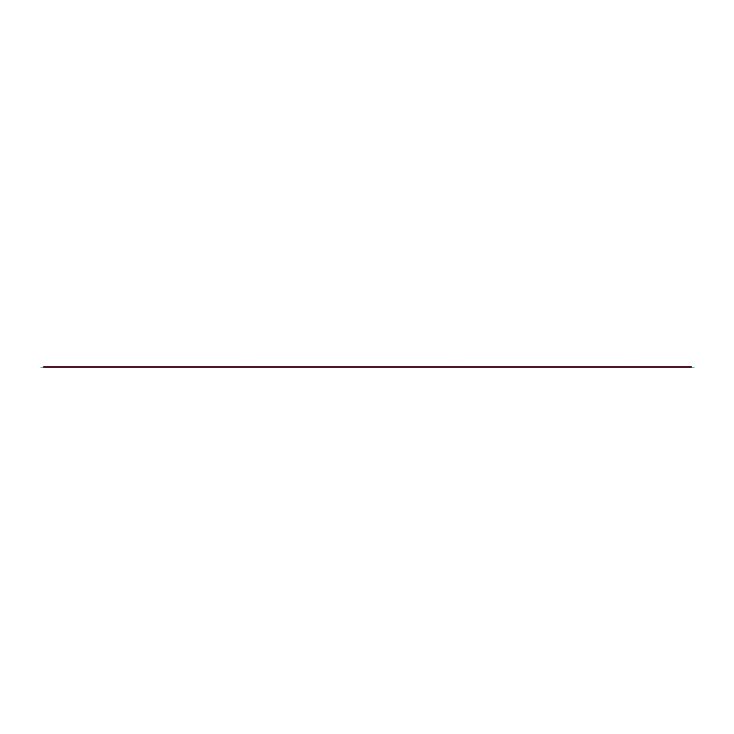

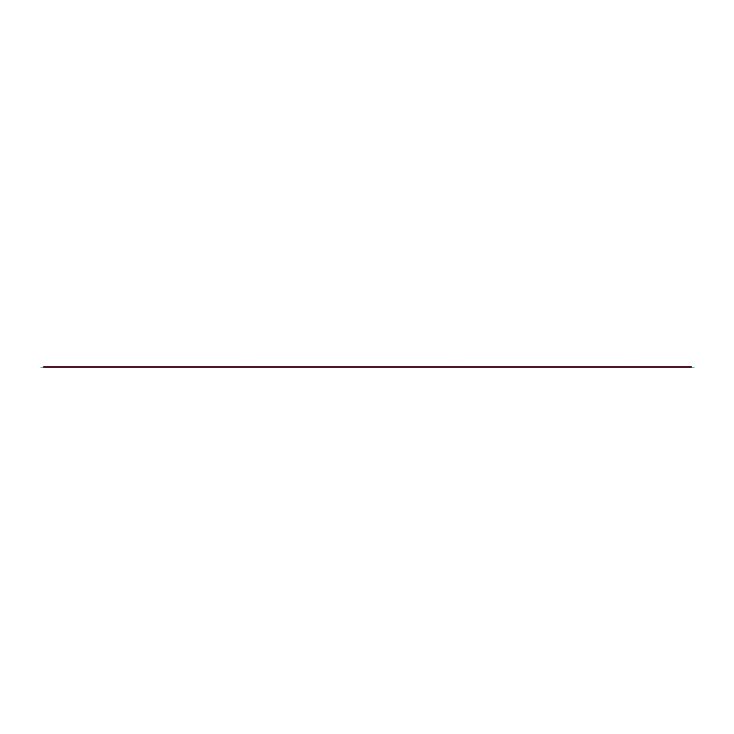

In [34]:
get_fig(processed_full, 60, 60)

In [48]:
test_env, test_obs = env.get_sb_env()

In [49]:
action, _states = model.predict(test_obs)

In [51]:
_states

In [ ]:
account, actions = agent.DRL_prediction(model, env)

In [ ]:
model = model.learn(total_timesteps=5000, tb_log_name=tb_log_name)
model.save(f"{config.TRAINED_MODEL_DIR}/{model_name.upper()}_{total_timesteps // 1000}k_{iter_num}")

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
======Model training from:  2017-01-06T00:00:00+07:00 to  2020-10-27T17:01:00+07:00
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cuda device
Logging to tensorboard_log/a2c\a2c_126_11
------------------------------------
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 74       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.45    |
|    explained_variance | -88.7    |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -0.193   |
|    std                | 1.03     |
|    value_loss         | 0.0128   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 6        |
|    iterations         | 200      |
|    time_elapsed   

In [ ]:
df_summary

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [ ]:
unique_trade_date = processed_full[(processed_full.date > val_test_start)&(processed_full.date <= val_test_end)].date.unique()

In [ ]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

In [ ]:
df_account_value.head()

In [ ]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

<a id='6.2'></a>
## 7.2 BackTestPlot

In [ ]:
print("==============Compare to IHSG===========")
%matplotlib inline
backtest_plot(df_account_value, 
             baseline_ticker = '^JKSE', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

<a id='6.3'></a>
## 7.3 Baseline Stats

In [ ]:
print("==============Get Baseline Stats===========")
baseline_perf_stats=get_baseline('^JKSE',
                                  start = df_account_value.loc[0,'date'],
                                  end = df_account_value.loc[len(df_account_value)-1,'date'])

#### 